# Предсказание оттока клиентов телеком компании

Задача: предсказать, покинет ли клиент компанию

Данные: информация о текущих клиентах компании, и о клиентах, которые отказались от услуг компании. Информация включает в себя сведения о поле, семейном положении, локации проживания, количестве номеров телефона, наличие онлайн ТВ и др. (подробнее в таблице)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('./train.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


$\textbf{Предварительно поделим признаки на категориальные и числовые. Отдельно выделим целевую переменную Churn}$

In [3]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols

# целевая переменная
target_col = 'Churn' 

$\textbf{Проанализируем число NaN-ов в каждом столбце}$

In [4]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

$\textbf{Как мы можем видеть, NaN-ов нет ни в одном столбце}$


$\textbf{Удалим строки, в которых присутствуют пустые значения в колонке TotalSpent, так как это мешает анализировать эту колонку}$

$\textbf{Таких строк не много, поэтому их удаление не окажет сильного влияния на конечный результат}$

$\textbf{Альтернативным вариантом могла бы быть замена значений TotalSpent в этих строчках на 0, если считать верным предположение о том, что:}$

$$TotalSpent = ClientPeriod \cdot MonthlySpending $$

In [5]:
data[data['TotalSpent'] == ' '].index # индексы строк с пустым занчением в колонке TotalSpent

Int64Index([1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598], dtype='int64')

In [6]:
# Удаление строчек, в которых присутствуют пустые значения в колонке TotalSpent
data = data.drop(data[data['TotalSpent'] == ' '].index)
data.TotalSpent = data.TotalSpent.astype(float)

In [7]:
# проанализируем числовые колонки
data[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5273.000000,5273.000000,5273.000000
mean,32.452304,64.956770,2291.390461
std,24.534723,30.177911,2269.014233
min,1.000000,18.250000,18.800000
25%,9.000000,35.500000,401.100000
50%,29.000000,70.450000,1410.250000
75%,55.000000,90.050000,3807.350000
max,72.000000,118.750000,8684.800000


In [8]:
data.info() # общие сведения о данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5273 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5273 non-null   int64  
 1   MonthlySpending           5273 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5273 non-null   object 
 4   IsSeniorCitizen           5273 non-null   int64  
 5   HasPartner                5273 non-null   object 
 6   HasChild                  5273 non-null   object 
 7   HasPhoneService           5273 non-null   object 
 8   HasMultiplePhoneNumbers   5273 non-null   object 
 9   HasInternetService        5273 non-null   object 
 10  HasOnlineSecurityService  5273 non-null   object 
 11  HasOnlineBackup           5273 non-null   object 
 12  HasDeviceProtection       5273 non-null   object 
 13  HasTechSupportAccess      5273 non-null   object 
 14  HasOnlin

$\textbf{Построим круговые диаграммы для всех категориальных колонок}$

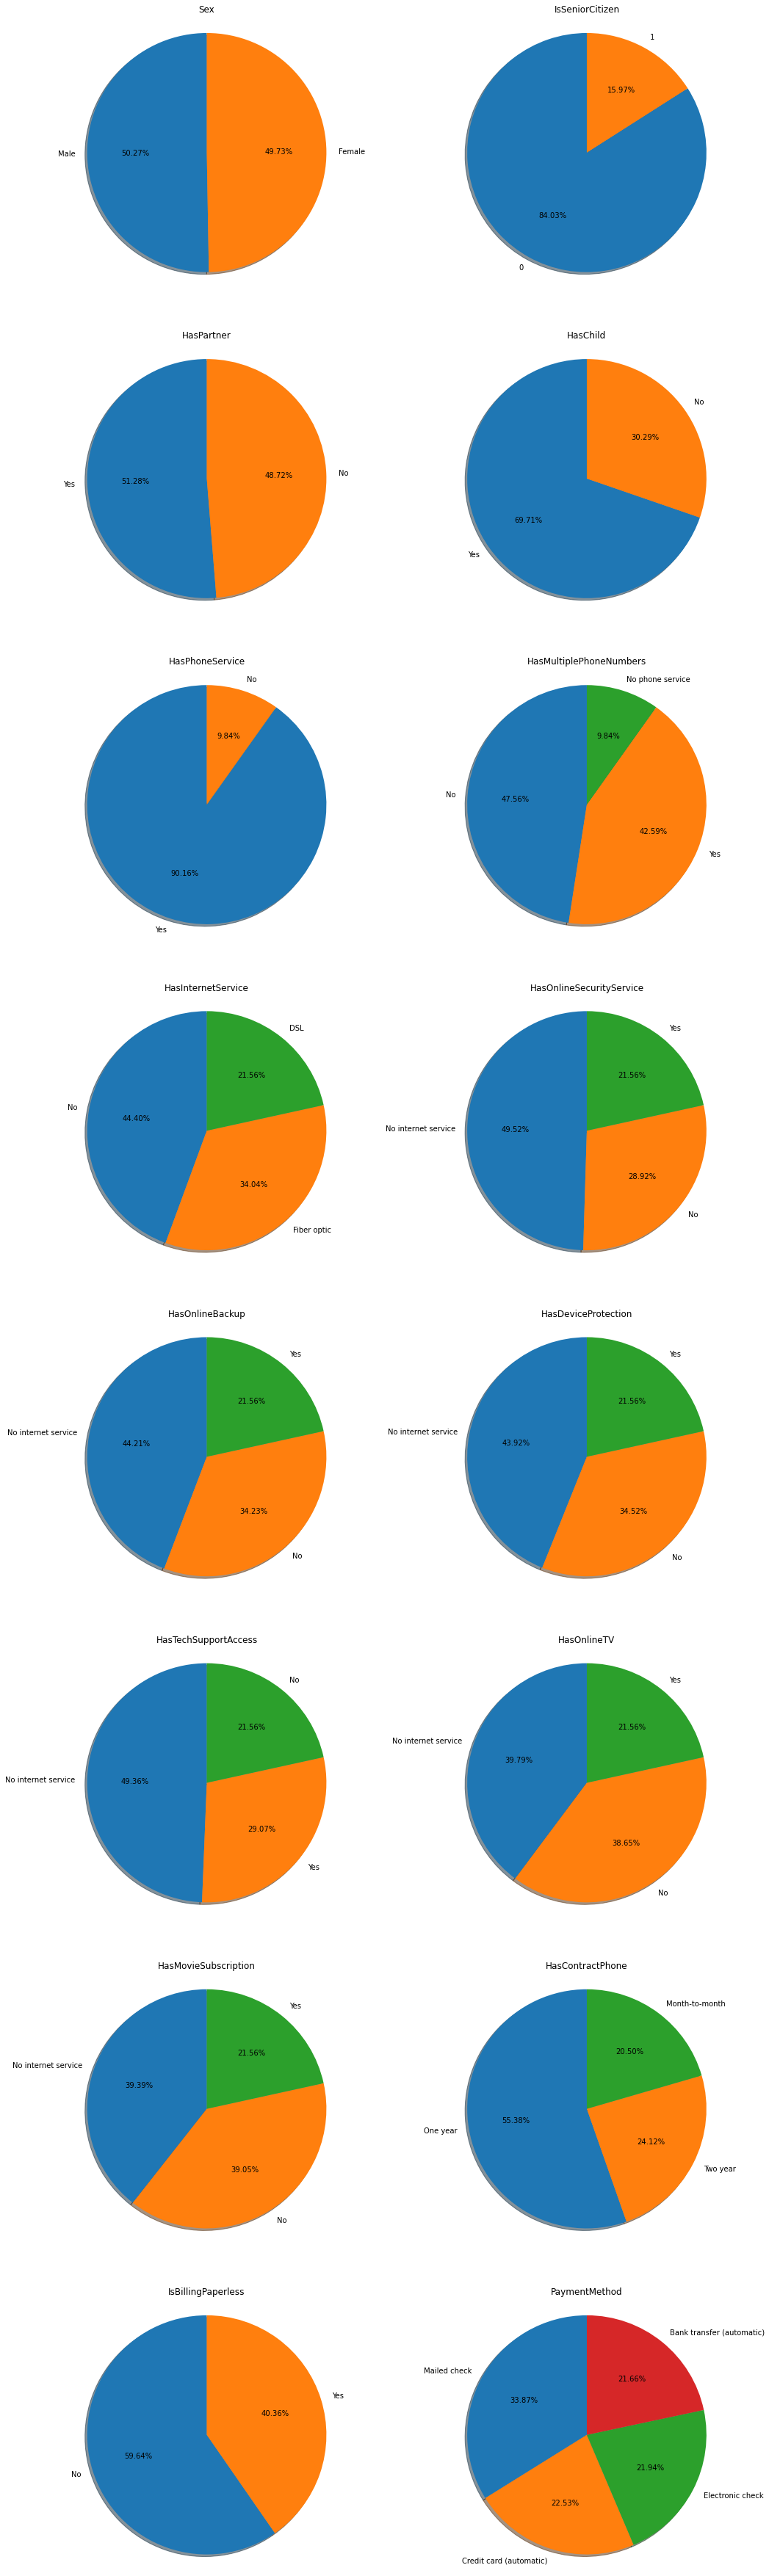

In [9]:
k = 1
plt.figure(figsize = (17, 64))
for col in cat_cols:    
    ax = plt.subplot(8, 2, k)
    ax.set_title(cat_cols[k - 1])
    labels = list(data[col].unique())
    ax.pie(data[col].value_counts(), labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, radius = 1.1)
    k += 1

$\textbf{Проверим, являются ли классы сбалансированными}$

In [10]:
data.Churn.value_counts()

0    3889
1    1384
Name: Churn, dtype: int64

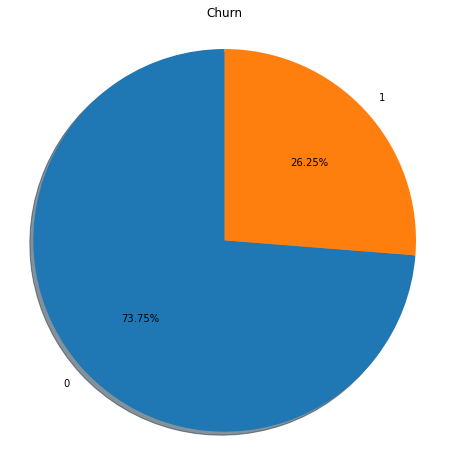

In [11]:
col = 'Churn'
plt.figure(figsize = (10, 8))
plt.title('Churn')
labels = list(data.Churn.unique())
plt.pie(data[col].value_counts(), labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, radius = 1.1)
None

$\textbf{Как видим, нулевой класс встречается почти в 4 раза чаще первый. Данные несбалансированны. Но этот дисбаланс не сильный (<10 раз)}$

$\textbf{Посмотрим на распределение целевой переменной в зависимоти от числовых и категориальных}$

$\textbf{В некоторых случаях такой анализ может дать представление об интересующих нас зависимостях}$

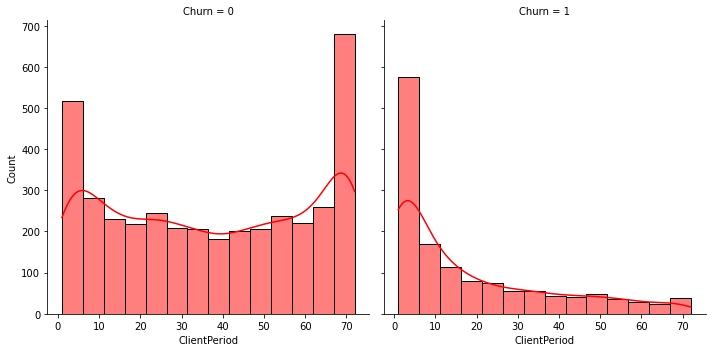

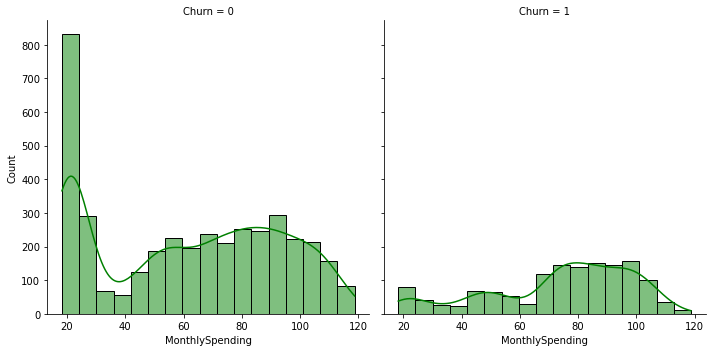

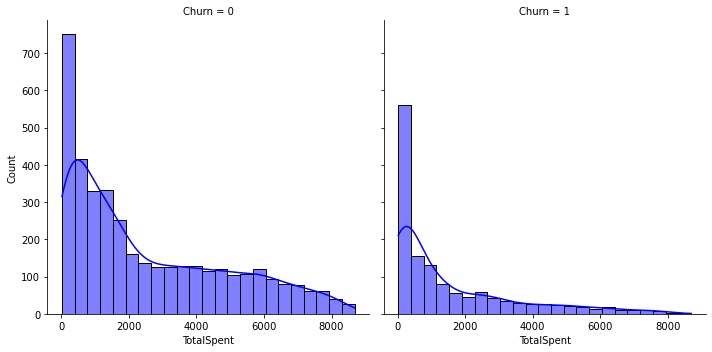

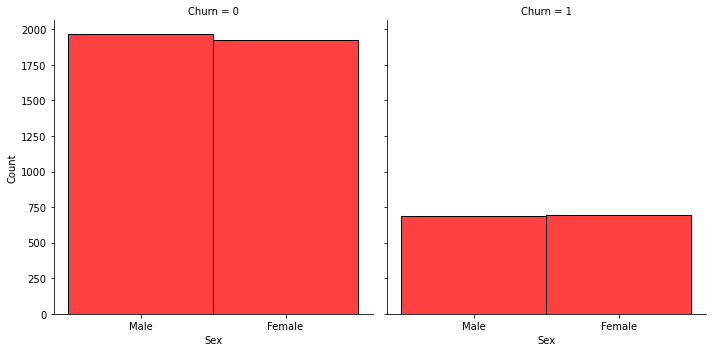

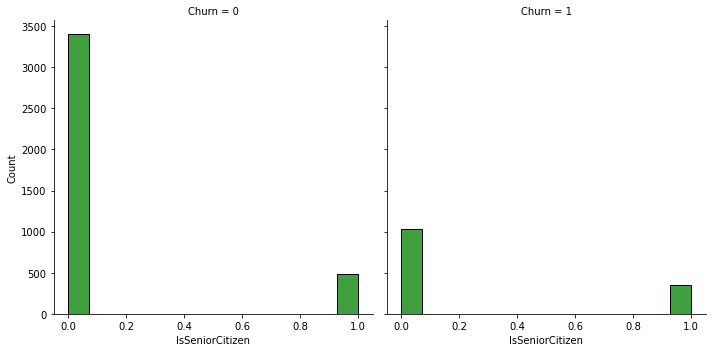

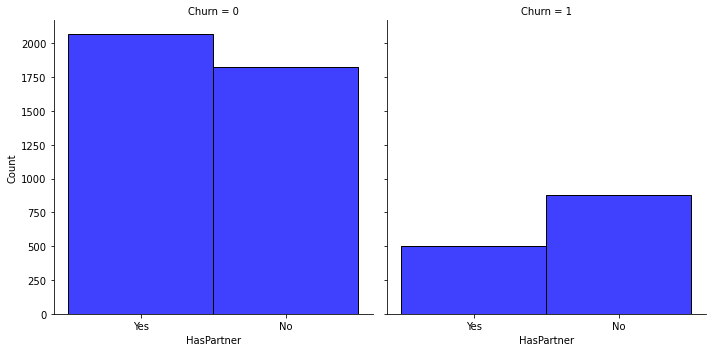

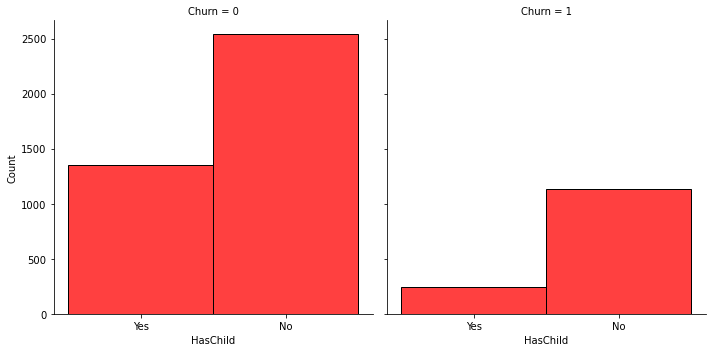

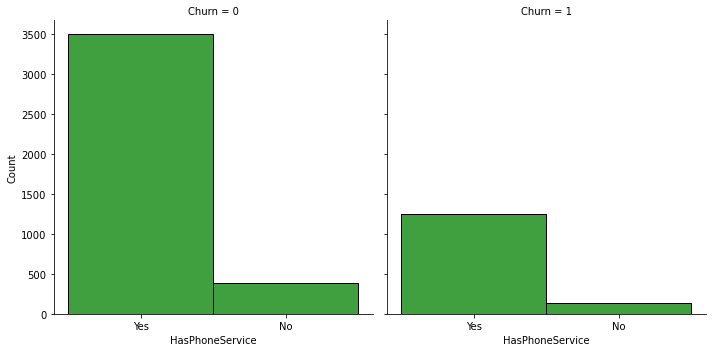

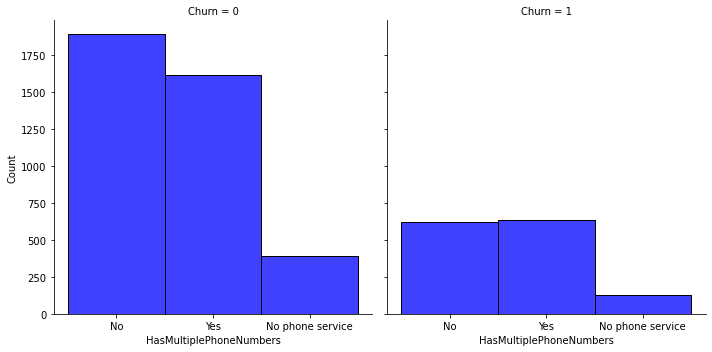

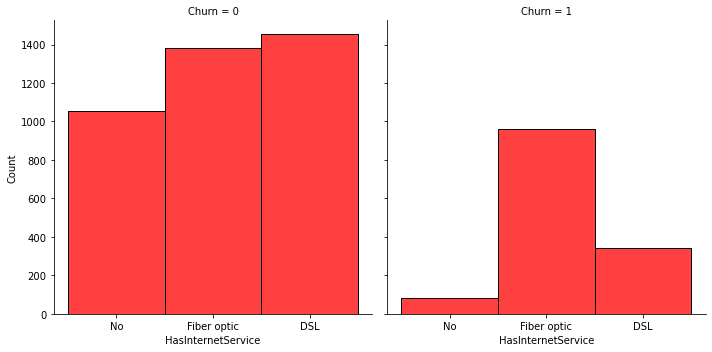

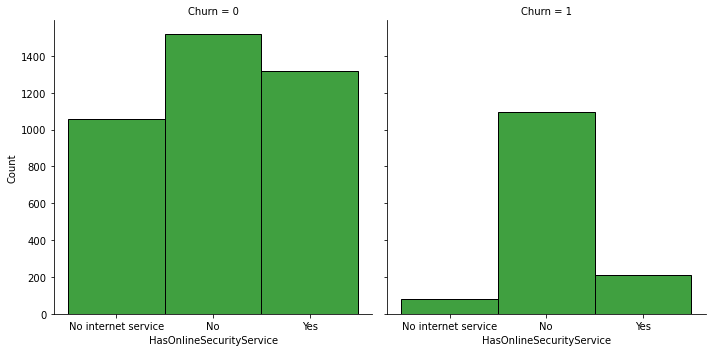

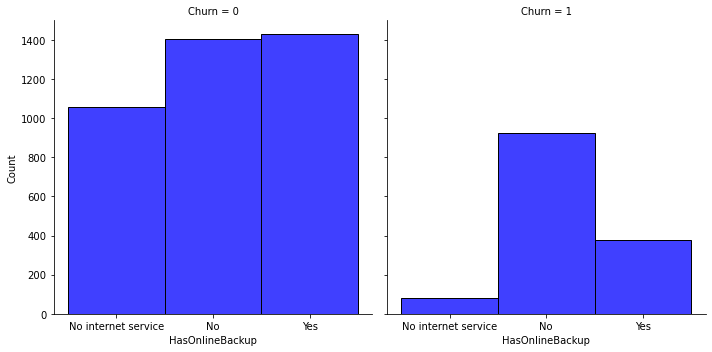

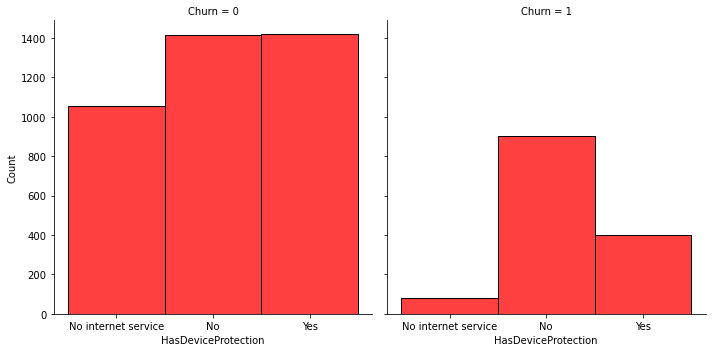

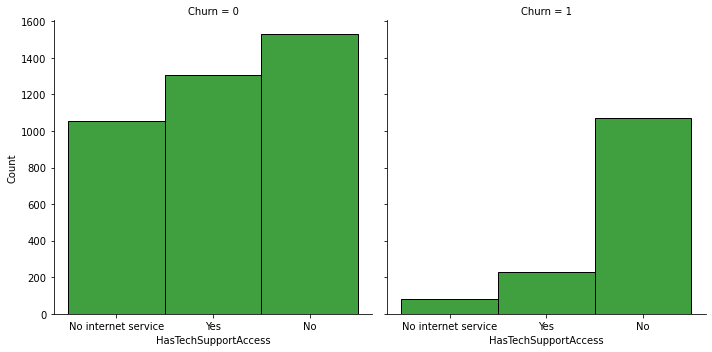

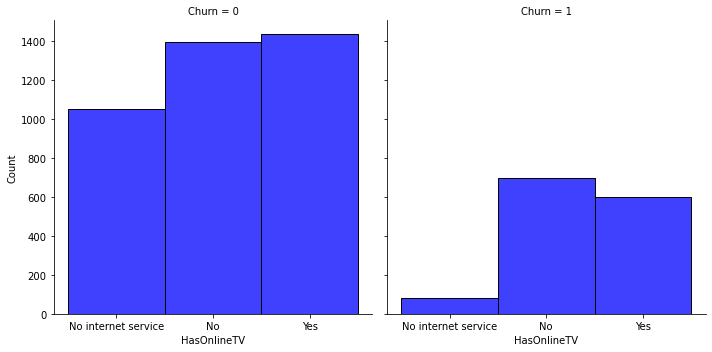

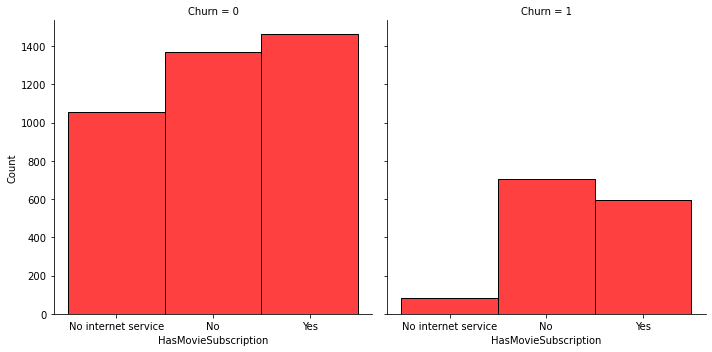

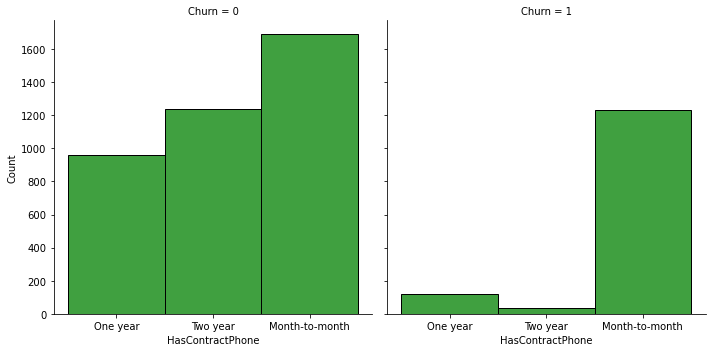

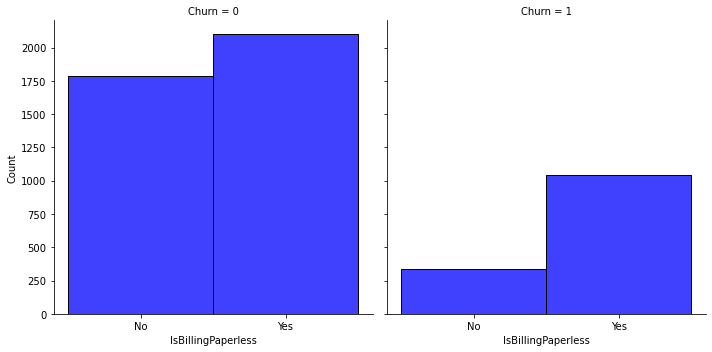

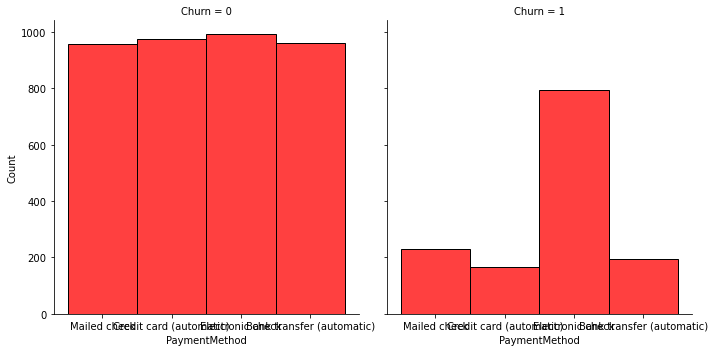

In [12]:
#распределение целевой переменной 
import seaborn as sns
color = ['r', 'g', 'b']

for i, x in enumerate(num_cols):
  sns.displot(data=data, x=x, col=target_col, kde=True, color = color[i % 3])

for i, x in enumerate(cat_cols):
  sns.displot(data=data, x=x, col=target_col, kde=False, color = color[i % 3])

None

$\Large\textbf{Применение моделей машинного обучения для предсказания оттока пользователей}$

$\textbf{В качестве $baseline$ применим логистическую регрессию. Для оценки качества модели используем ROC-UAC score}$

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

1) Преобразуем (нормируем) числовые признаки с помощью StandardScaler (линейные модели работаю хорошо только с тнормированными признаками), пропущенные значения заменяем с помощью SimpleImputer на медианное значение.

2) Категориальные признаки превращаем в one-hot вектора с помощью OneHotEncoder. 

3) Создаём Pipeline, состоящий из функции предобработки признаков и применяемой модели

4) Задаём сетку гиперпрараметров, по которой будем искать оптимальные гиперпараметры для модели с помощью GridSearchCV

In [14]:
# преобразование числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# преобразование категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])

# общая предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

# классификатор (модель)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

# сетка гиперпараметров
param_grid = [{
    'classifier__C': [100, 10, 1, 0.5, 0.1, 0.01], 
    'classifier__penalty': ['l2']
}]

In [15]:
# Используем GridSearchCV для поиска оптимальных гиперпараметров 
LogRer_Std_grid_search = GridSearchCV(clf, 
                            param_grid, 
                            cv=5,
                            n_jobs=-1,
                            refit=True,
                            scoring='roc_auc')  

LogRer_Std_grid_search.fit(data[feature_cols], data[target_col])

print(LogRer_Std_grid_search.best_params_)
print(LogRer_Std_grid_search.best_score_)

{'classifier__C': 100, 'classifier__penalty': 'l2'}
0.8448208909105489


In [16]:
print('best_param_C =', LogRer_Std_grid_search.best_params_['classifier__C'])
print('best_param_penalty =', LogRer_Std_grid_search.best_params_['classifier__penalty'])
print('best_roc_auc_score = ', LogRer_Std_grid_search.best_score_)

best_param_C = 100
best_param_penalty = l2
best_roc_auc_score =  0.8448208909105489


$\textbf{Вывод: удалось добиться качества 0.84 по метрике ROC-AUC на тестовых данных}$

$\textbf{Попробуем использовать RandomForestClassifier}$

In [66]:
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state = 42, n_jobs = -1))])



param_grid = [{
    'classifier__max_depth': [2, 5, 10, 20, 40],
    'classifier__n_estimators': np.arange(2, 100, 4),
    'classifier__min_samples_leaf': [2, 4, 8, 16, 20],
    'classifier__criterion': ['gini', 'entropy']
    }]

Random_Forest_grid_search = GridSearchCV(
                            clf,
                            param_grid,              
                            cv=3,
                            n_jobs=-1,
                            refit=True,
                            scoring='roc_auc')    
    
Random_Forest_grid_search.fit(data[feature_cols], data[target_col])

print('best_param_max_depth =', Random_Forest_grid_search.best_params_['classifier__max_depth'])
print('best_param_n_estimators =', Random_Forest_grid_search.best_params_['classifier__n_estimators'])
print('best_param_min_samples_leaf =', Random_Forest_grid_search.best_params_['classifier__min_samples_leaf'])
print('best_param_criterion =', Random_Forest_grid_search.best_params_['classifier__criterion'])
print('best_roc_auc_score = ', Random_Forest_grid_search.best_score_)

best_param_max_depth = 10
best_param_n_estimators = 50
best_param_min_samples_leaf = 20
best_param_criterion = gini
best_roc_auc_score =  0.8448094363478456


$\textbf{RandomForestClassifier даёт примерно такое же качество, как и логистическая регрессия: 0.845 по метрике ROC-AUC}$

$\textbf{Попробуем использовать градиентный бустинг для достижения более высокого результата}$

$\textbf{В качестве модели применим CatBoostClassifier}$

In [18]:
!pip install catboost

In [15]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train_data, validation_data, train_target, validation_target = train_test_split(data[feature_cols],
                                                                                data[target_col],
                                                                                test_size=0.1,
                                                                                random_state = 2)


CBC = CatBoostClassifier(cat_features = cat_cols,
                         logging_level = 'Silent'                        
                        ) 


CBC.fit(train_data, train_target)

In [16]:
y_pred = CBC.predict_proba(validation_data)[:, 1]
score = roc_auc_score(validation_target, y_pred)
score

0.8543849869936825

$\textbf{Результат, полученный на дефолтных параметрах, превосходит результат логистической регрессии}$

$\textbf{Попробуем улучшить результат, подобрав наилучшие гиперпараметры с помощью grid_search}$

In [32]:
CBC_1 = CatBoostClassifier(cat_features = cat_cols,
                         logging_level = 'Silent',
                         custom_loss = 'Accuracy',
                         eval_metric = 'AUC:hints=skip_train~false'
                        ) 

param_grid_1 = [{'max_depth': [1, 2, 4, 8],
               'learning_rate': [0.25, 0.2, 0.1, 0.05, 0.01],
               'num_trees': [50, 100, 200, 500, 800]}]


grid_search_result_1 = CBC_1.grid_search(param_grid_1,
                                    X = data[feature_cols],
                                    y = data[target_col],
                                    cv=3,
                                    calc_cv_statistics=True,
                                    search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=True,
                                    train_size=0.8,
                                    verbose=False,
                                    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Как видно, при максимальной глубине дерева больше 4 модель переобучается (на трейне ошибка почти нулевая, а на тесте больше, чем при меньшей глубине дерева - это ожидаемый результат). 

### Маленький learning rate $(\le 0.05)$ даёт результаты хуже, чем больший lerning rate при любом числе итераций, но при маленьком числе итераций эта разница ярко выражена (это видно по просадкам в графике - модель не успевает обучиться, так как итераций мало и lerning rate тоже маленький). Поэтому можно сузить диапозон параметров. 

In [34]:
CBC_2 = CatBoostClassifier(cat_features = cat_cols,
                         logging_level = 'Silent',
                         custom_loss = 'Accuracy',
                         eval_metric = 'AUC:hints=skip_train~false'
                        ) 


param_grid_2 = [{'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.5, 0.25, 0.2, 0.1],
               'num_trees': [20, 50, 100, 200, 400, 500, 800, 1000]}]


grid_search_result_2 = CBC_2.grid_search(param_grid_2,
                                    X = data[feature_cols],
                                    y = data[target_col],
                                    cv=3,
                                    calc_cv_statistics=True,
                                    search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=True,
                                    train_size=0.8,
                                    verbose=False,
                                    plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Сузим поиск ещё немного. Вероятно, это уже излишне, но может дать небольшой прирост в качестве. 

### Например, при максимальной глубине дерева > 2 модель уже заметно переобучается.  Поэтому рассмотри только деревья глубиной 1 и 2

In [35]:
CBC_3 = CatBoostClassifier(cat_features = cat_cols,
                         logging_level = 'Silent',
                         custom_loss = 'Accuracy',
                         eval_metric = 'AUC:hints=skip_train~false'
                        ) 


param_grid_3 = [{'max_depth': [1, 2],
               'learning_rate': [0.4, 0.25, 0.2, 0.125],
               'num_trees': [100, 200, 400, 500, 800]}]


grid_search_result_3 = CBC_3.grid_search(param_grid_3,
                                    X = data[feature_cols],
                                    y = data[target_col],
                                    cv=3,
                                    calc_cv_statistics=True,
                                    search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=True,
                                    train_size=0.8,
                                    verbose=False,
                                    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Итоговое качество на валидации составило 0.868, что лучше, чем у логистической регрессии, RandomForestClassifier или CatBoostClassifier с параметрами по умолчанию

### Чтобы ещё немного улучшить результат, воспользуемся StackingClassifier-ом на трех лучших моделях, полученных выше. 

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


estimators = [('cbc1', CBC_1),('cbc2', CBC_2), ('cbc3', CBC_3)]

clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(), cv = 3)

# y_pred = clf.fit(train_data, train_target).predict(validation_data)
# y_pred_prob = clf.fit(train_data, train_target).predict_proba(validation_data)[:, 1]

# print(accuracy_score(y_pred, validation_target))
# print(roc_auc_score(validation_target, y_pred_prob))


clf.fit(data[feature_cols], data[target_col])

StackingClassifier(cv=3,
                   estimators=[('cbc1',
                                <catboost.core.CatBoostClassifier object at 0x00000169229038E0>),
                               ('cbc2',
                                <catboost.core.CatBoostClassifier object at 0x0000016922A8A4F0>),
                               ('cbc3',
                                <catboost.core.CatBoostClassifier object at 0x0000016922A8A460>)],
                   final_estimator=LogisticRegression())

# Предсказания

In [47]:
# выбор лучшей модели
best_model = clf # CBC_1, CBC_2, CBC_3, Random_Forest_grid_search, LogRer_Std_grid_search

In [48]:
# обучение лучшей модели
best_model.fit(data[feature_cols], data[target_col])

In [49]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

### Удалось добиться качества 0.853 по метрике ROC-AUC на тестовой выборке, засабмиченной на Kaggle